# Weekly project 6
Today we will continue work from monday.
We will follow the style of last week.

Weekly project:
- You will need to implement your own k-means algorithm. (So you are not allowed to use the one in *sklearn*
- it should be able to cluster each of the different figures.
- Extend your k-means so it finds the optimal amount of clusters.
Challenge
- Implement the mean shift clustering algorithm


In [1]:
import numpy as np
import open3d as o3d
import copy
import matplotlib.pyplot as plt

def draw_labels_on_model(pcl, labels):
    cmap = plt.get_cmap("tab20")
    pcl_temp = copy.deepcopy(pcl)
    max_label = labels.max()
    colors = cmap(labels / (max_label if max_label > 0 else 1))
    colors[labels < 0] = 0
    pcl_temp.colors = o3d.utility.Vector3dVector(colors[:, :3])
    o3d.visualization.draw_geometries([pcl_temp])

d = 4
mesh = o3d.geometry.TriangleMesh.create_tetrahedron().translate((-d, 0, 0))
mesh += o3d.geometry.TriangleMesh.create_octahedron().translate((0, 0, 0))
mesh += o3d.geometry.TriangleMesh.create_icosahedron().translate((d, 0, 0))
mesh += o3d.geometry.TriangleMesh.create_torus().translate((-d, -d, 0))
mesh += o3d.geometry.TriangleMesh.create_moebius(twists=1).translate((0, -d, 0))
mesh += o3d.geometry.TriangleMesh.create_moebius(twists=2).translate((d, -d, 0))

## apply k means on this
point_cloud = mesh.sample_points_uniformly(int(1e3))

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2022-03-17 08:42:54,383 - utils - NumExpr defaulting to 8 threads.


In [ ]:
o3d.visualization.draw_geometries([point_cloud])

In [3]:

##draw labels on the point cloud
def draw_labels_on_model(pcl,labels):
    cmap = plt.get_cmap("tab20")
    pcl_temp = copy.deepcopy(pcl)
    max_label = labels.max()
    colors = cmap(labels / (max_label if max_label > 0 else 1))
    pcl_temp.colors = o3d.utility.Vector3dVector(colors[:,:3])
    o3d.visualization.draw_geometries([pcl_temp])

In [96]:
xyz = np.asarray(point_cloud.points)

##define several necessary methods here
#normalize the dataset
def normalize(X,axis=-1,p=2):
    #normalize the array and then transfer into a vector
    lp_norm = np.atleast_1d(np.linalg.norm(X,p,axis))
    lp_norm[lp_norm == 0] = 1
    #expand a dimension along axis for lp_norm
    #this is to make sure X and lp_norm have the same dimensions
    return X / np.expand_dims(lp_norm,axis)

def euclidean_distance(one_sample,X):
    #transfer one_sample into 1D vector
    one_sample = one_sample.reshape(1,-1)
    #transfer X into 1D vector
    X = X.reshape(X.shape[0],-1)
    #this is used to make sure one_sample's dimension is same as X
    distances = np.power(np.tile(one_sample,(X.shape[0],1))-X,2).sum(axis=1)
    return distances

class Kmeans():
    #constructor
    def __init__(self,k=2,max_iterations=1500,tolerance=0.00001):
        self.k = k
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.n_features = 1000
        self.centroids = np.zeros((self.k,self.n_features))  
    
    #randomly select k centroids
    def init_random_centroids(self,X):
        #save the shape of X
        n_samples, n_features = np.shape(X)
        #make a zero matrix to store values
        centroids = np.zeros((self.k,n_features))
        #bcs there is k centroids, so we loop k tiems
        for i in range(self.k):
            #selecting values under the range radomly
            centroid = X[np.random.choice(range(n_samples))]
            centroids[i] = centroid
        return centroids

    #find the closest centroid of a sample
    def closest_centroid(self,sample,centroids):
        distances = euclidean_distance(sample,centroids)
        #np.argmin return the indices of the minimum of distances
        closest_i = np.argmin(distances)
        return closest_i

    #determine the clusers
    def create_clusters(self,centroids,X):
        n_samples = np.shape(X)[0]
        #This is to construct the nested list for storing clusters
        clusters = [[] for _ in range(self.k)]
        for sample_i, sample in enumerate(X):
            centroid_i = self.closest_centroid(sample,centroids)
            clusters[centroid_i].append(sample_i)
        self.clusters = clusters
        return clusters

    #update the centroids based on mean algorithm
    def update_centroids(self,clusters,X):
        n_features = np.shape(X)[1]
        centroids = np.zeros((self.k,n_features))
        for i, cluster in enumerate(clusters):
            centroid = np.mean(X[cluster],axis=0)
            centroids[i] = centroid
        self.centroids = centroids
        return centroids

    #obtain the labels
    #same cluster, same y_pred value
    def get_cluster_labels(self,clusters,X):
        y_pred = np.zeros(np.shape(X)[0])
        for cluster_i, cluster in enumerate(clusters):
            for sample_i in cluster:
                y_pred[sample_i] = cluster_i
        return y_pred

    #predict the labels
    def predict(self,X):
        #selecting the centroids randomly
        centroids = self.init_random_centroids(X)

        for _ in range(self.max_iterations):
            #clustering all the data point
            clusters = self.create_clusters(centroids,X)
            former_centroids = centroids
            #calculate new cluster center
            centroids = self.update_centroids(clusters,X)
            #judge the current difference if it meets convergence  
            diff = centroids - former_centroids
            if diff.any() < self.tolerance:
                break
            
        return self.get_cluster_labels(clusters,X) 
    
    def plot_distortion(self,X):
        distort = 0
        for sample_i, sample in enumerate(X):
            centroid_i = self.closest_centroid(sample,self.centroids)
            distort += np.sum(np.square(np.abs(sample-self.centroids[centroid_i])))
        return distort

In [95]:
clf = Kmeans(k=6)
labels = clf.predict(xyz)
print(clf.plot_distortion(xyz))
#draw_labels_on_model(point_cloud, labels)

[[ 3.04438290e+00 -3.68255001e-01  3.07996935e-01]
 [ 4.87935584e+00 -3.11132064e-01  5.17381842e-01]
 [-3.99833352e+00 -3.23191964e+00  8.85601080e-04]
 [ 4.00345771e+00  6.96006809e-01 -8.74447247e-01]
 [ 3.80637026e+00 -4.03515619e+00 -4.78178134e-03]
 [-2.05827975e-02 -1.80286260e+00 -5.12780722e-03]]
2690.681047685573


[5877.361996999148, 4319.84496992966, 2963.7926995734647, 2378.0984720250763, 2444.4753912748088, 1730.7134433685849, 1668.2157303749887, 1095.657531509165, 1105.656485588613, 1025.5805342706562, 912.4350058859263, 842.688201868953, 759.304928041893, 914.6962412353823]


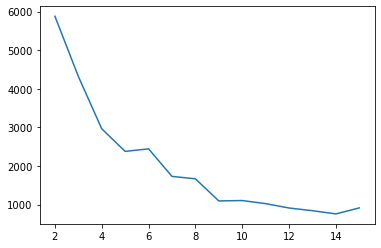

In [108]:
limit = 15
clustering = []
for k in range(2,limit+1):
    clf = Kmeans(k=k)
    labels = clf.predict(xyz)
    plot_distortion = clf.plot_distortion(xyz)
    clustering.append(plot_distortion)
    
print(clustering)
plt.plot(range(2,limit+1),clustering)

In [104]:
print(clustering[1])

[3, 4715.257791548838]


In [14]:
def init_random_centroids(X):
    #save the shape of X
    k=6
    n_samples, n_features = np.shape(X)
    #make a zero matrix to store values
    centroids = np.zeros((k,n_features))
    #bcs there is k centroids, so we loop k tiems
    for i in range(k):
        #selecting values under the range radomly
        centroid = X[np.random.choice(range(n_samples))]
        centroids[i] = centroid
    return centroids

print(init_random_centroids(xyz))
print(xyz.shape)
n_samples, n_featuQres = np.shape(xyz)
print(np.random.choice(range(n_samples)))

[[ 3.66960625  1.29408604  0.9935542 ]
 [ 3.28345381  1.07431182 -0.82717598]
 [-4.21482804 -5.46691418  0.07782658]
 [-0.49893556 -0.15086419  0.35020025]
 [ 5.30547996 -0.039546    0.81827708]
 [ 4.43135395 -1.45327144  0.57487836]]
(1000, 3)
474


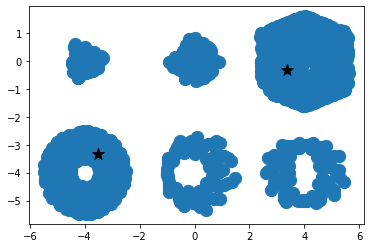

In [110]:
class Mean_Shift:
    def __init__(self, radius=4):
        self.radius = radius
    def fit(self, data):
        centroids = {}

        for i in range(len(data)):
            centroids[i] = data[i]
        while True:
            new_centroids = []
            for i in centroids:
                in_bandwidth = []
                centroid = centroids[i]
                for featureset in data:
                    if np.linalg.norm(featureset-centroid) < self.radius:
                        in_bandwidth.append(featureset)

                new_centroid = np.average(in_bandwidth,axis=0)
                new_centroids.append(tuple(new_centroid))

            uniques = sorted(list(set(new_centroids)))
            prev_centroids = dict(centroids)

            centroids = {}
            for i in range(len(uniques)):
                centroids[i] = np.array(uniques[i])

            optimized = True

            for i in centroids:
                if not np.array_equal(centroids[i], prev_centroids[i]):
                    optimized = False
                if not optimized:
                    break
                
            if optimized:
                break

        self.centroids = centroids
        
clf = Mean_Shift()
clf.fit(xyz)

centroids = clf.centroids

plt.scatter(xyz[:,0], xyz[:,1], s=150)

for c in centroids:
    plt.scatter(centroids[c][0], centroids[c][1], color='k', marker='*', s=150)

plt.show()